In [1]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import powerlaw
import pandas as pd
from datetime import datetime, timedelta

# Pregunta 1

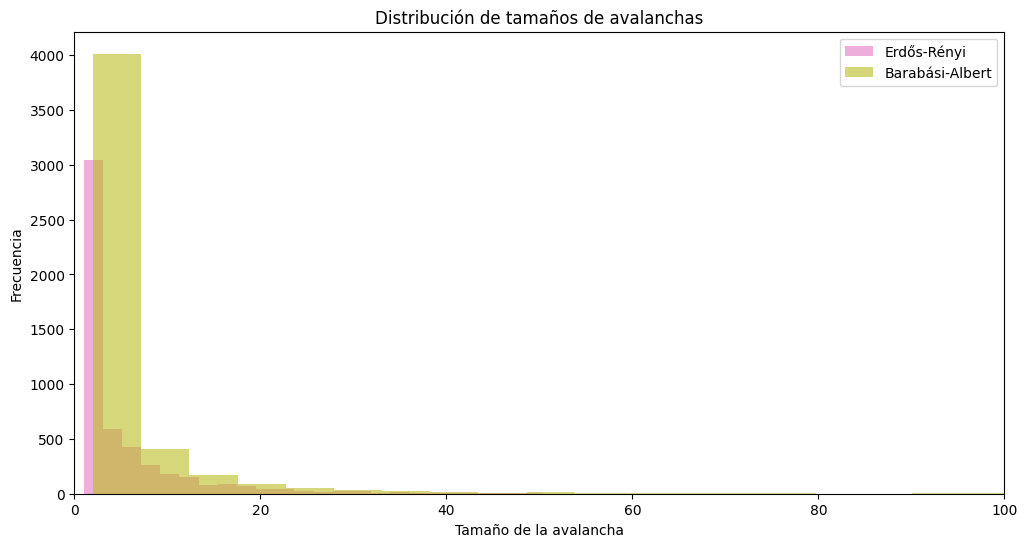

In [2]:
N = 1000
average_degree = 2

p = average_degree / (N - 1)
G_er = nx.erdos_renyi_graph(N, p)

m = average_degree // 2
G_ba = nx.barabasi_albert_graph(N, m)

def initialize_buckets(G):
    buckets = {node: np.random.randint(0, G.degree(node) + 1) for node in G.nodes()}
    return buckets

def add_grain(G, buckets):
    node = np.random.choice(G.nodes())
    return avalanche(G, buckets, node)

def avalanche(G, buckets, node):
    stack = [node]
    grains_transferred = 0
    while stack:
        current = stack.pop()
        buckets[current] += 1
        if buckets[current] > G.degree(current):
            grains_transferred += buckets[current]
            buckets[current] = 0
            neighbors = list(G.neighbors(current))
            for neighbor in neighbors:
                if np.random.rand() > 0.001:
                    stack.append(neighbor)
    return grains_transferred

def simulate_avalanches(G, iterations):
    buckets = initialize_buckets(G)
    avalanche_sizes = []
    for _ in range(iterations):
        size = add_grain(G, buckets)
        if size > 0:
            avalanche_sizes.append(size)
    return avalanche_sizes

# Simulación
iterations = 10000
avalanche_sizes_er = simulate_avalanches(G_er, iterations)
avalanche_sizes_ba = simulate_avalanches(G_ba, iterations)

# Graficar las distribuciones
plt.figure(figsize=(12, 6))
plt.hist(avalanche_sizes_er, bins=50, alpha=0.6, label='Erdős-Rényi', color='tab:pink')
plt.hist(avalanche_sizes_ba, bins=50, alpha=0.6, label='Barabási-Albert',color='tab:olive')
plt.xlabel('Tamaño de la avalancha')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Distribución de tamaños de avalanchas')
plt.xlim(0, 100)
plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


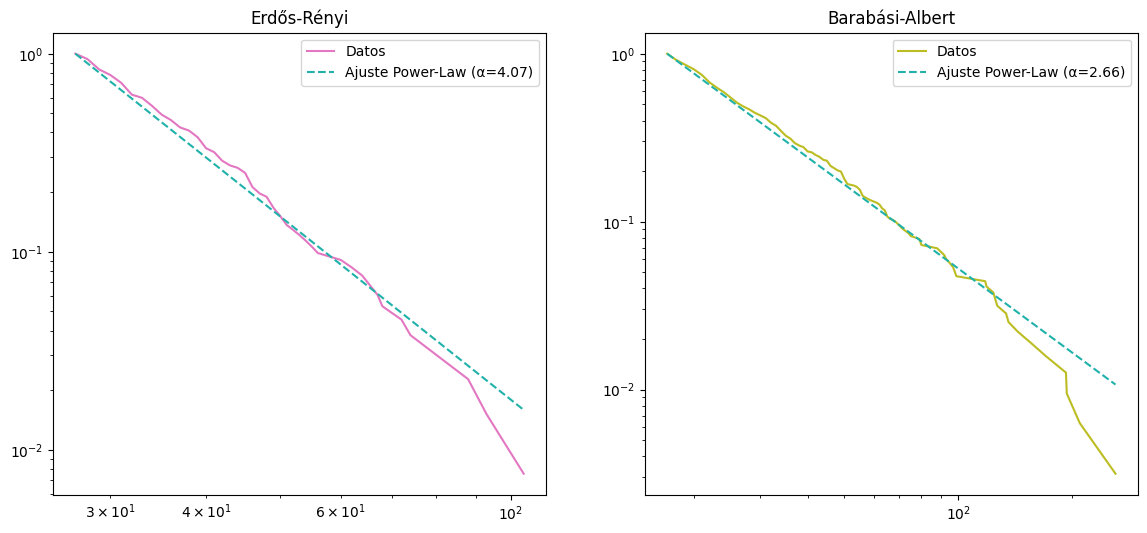

In [3]:

avalanche_sizes_er = np.array(avalanche_sizes_er)
avalanche_sizes_ba = np.array(avalanche_sizes_ba)

fit_er = powerlaw.Fit(avalanche_sizes_er[avalanche_sizes_er > 0])
fit_ba = powerlaw.Fit(avalanche_sizes_ba[avalanche_sizes_ba > 0])

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Erdős-Rényi')
fit_er.plot_ccdf(ax=ax[0], label='Datos', color='tab:pink')
fit_er.power_law.plot_ccdf(linestyle='--', ax=ax[0], label=f'Ajuste Power-Law (α={fit_er.power_law.alpha:.2f})', color='lightseagreen')
ax[0].legend()

ax[1].set_title('Barabási-Albert')
fit_ba.plot_ccdf(ax=ax[1], label='Datos', color='tab:olive')
fit_ba.power_law.plot_ccdf(linestyle='--', ax=ax[1], label=f'Ajuste Power-Law (α={fit_ba.power_law.alpha:.2f})', color='lightseagreen')
ax[1].legend()

plt.show()

# Pregunta 3

In [4]:
file_path = './Datos/primaryschool.csv'
df = pd.read_csv(file_path, delimiter='\t', header=None)
df.columns = ['timestamp', 'ID1', 'ID2', 'class1', 'class2']

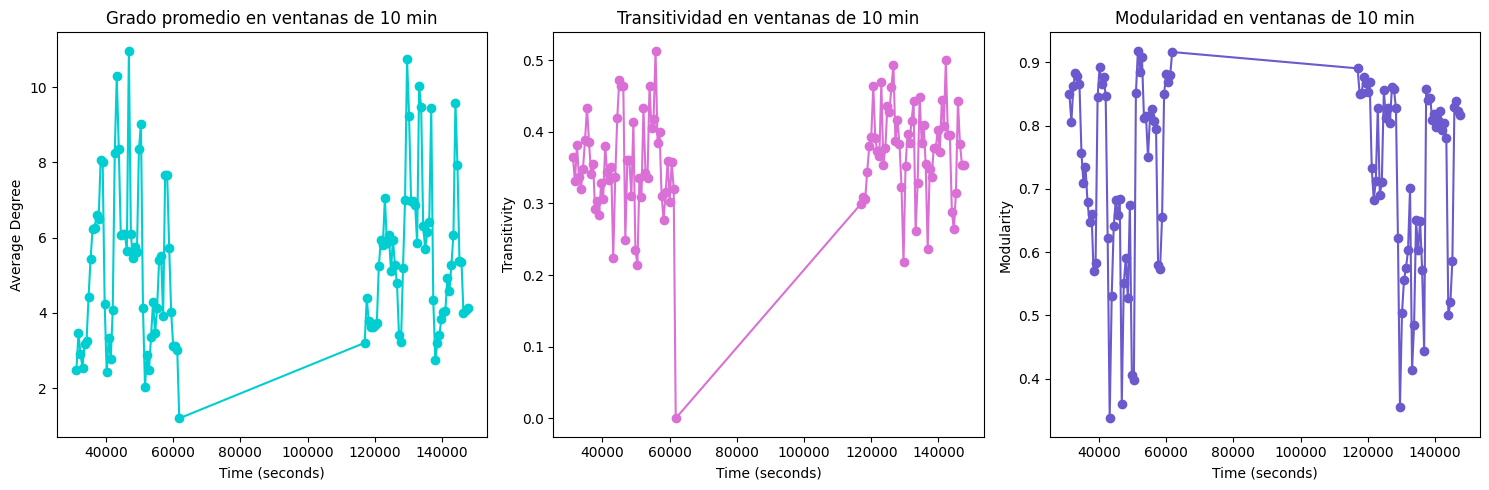

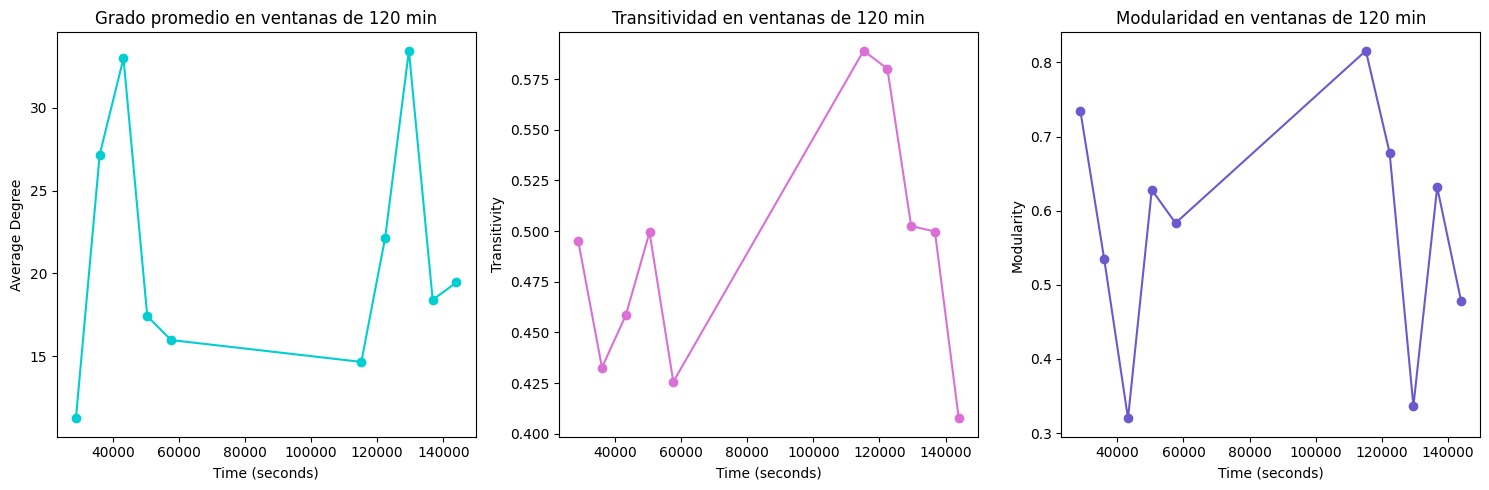

In [5]:
file_path = './Datos/primaryschool.csv'
data = pd.read_csv(file_path, sep='\t', header=None)

window_sizes = [600, 7200]

def calculate_modularity(G):
    from networkx.algorithms.community import greedy_modularity_communities
    communities = greedy_modularity_communities(G)
    modularity = nx.algorithms.community.quality.modularity(G, communities)
    return modularity

for window_size in window_sizes:
    data['window'] = (data[0] // window_size) * window_size

    avg_degree = []
    transitivity = []
    modularity = []

    windows = data['window'].unique()

    for window in sorted(windows):
        window_data = data[data['window'] == window]
        G = nx.Graph()
        edges = window_data[[1, 2]].values
        G.add_edges_from(edges)

        avg_degree.append(np.mean([d for n, d in G.degree()]))
        transitivity.append(nx.transitivity(G))
        modularity.append(calculate_modularity(G))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(sorted(windows), avg_degree, marker='o', color='darkturquoise')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Degree')
    plt.title(f'Grado promedio en ventanas de {window_size // 60} min')

    plt.subplot(1, 3, 2)
    plt.plot(sorted(windows), transitivity, marker='o', color='orchid')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Transitivity')
    plt.title(f'Transitividad en ventanas de {window_size // 60} min')

    plt.subplot(1, 3, 3)
    plt.plot(sorted(windows), modularity, marker='o', color='slateblue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Modularity')
    plt.title(f'Modularidad en ventanas de {window_size // 60} min')

    plt.tight_layout()
    plt.show()

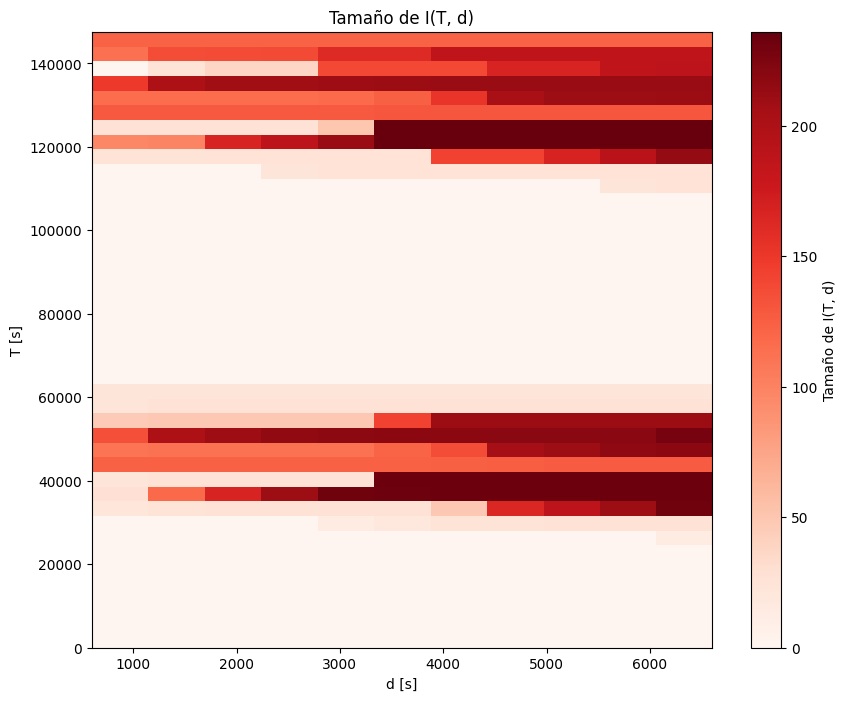

In [6]:
student_id = 1695

T_values = range(0, int(data[0].max()), 3600)  
d_values = range(600, 7200, 600)

influence_matrix = np.zeros((len(T_values), len(d_values)))

for i, T in enumerate(T_values):
    for j, d in enumerate(d_values):
        window_data = data[(data[0] >= T) & (data[0] < T + d)]
        G = nx.Graph()
        edges = window_data[[1, 2]].values
        G.add_edges_from(edges)

        if G.has_node(student_id):
            reachable_nodes = nx.node_connected_component(G, student_id)
            influence_matrix[i, j] = len(reachable_nodes)
        else:
            influence_matrix[i, j] = 0

plt.figure(figsize=(10, 8))
plt.imshow(influence_matrix, aspect='auto', cmap='Reds', origin='lower', extent=[d_values[0], d_values[-1], T_values[0], T_values[-1]])
plt.colorbar(label='Tamaño de I(T, d)')
plt.xlabel('d [s]')
plt.ylabel('T [s]')
plt.title('Tamaño de I(T, d)')
plt.show()